A. Esad Uğur -  Hasan F. Durkaya

Github Repo: https://github.com/Esad-U/OCT-Generation-Project/tree/main

# OCT-Generation-Project

Importing Necessary Libraries

In [13]:
import os
import logging
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime

# Dataset Implementation
 
The `ComplexFourierDataset` class handles loading and preprocessing of image sequences. It:
 - Loads images from directories
 - Converts them to Fourier domain
 - Separates magnitude and phase information
 - Splits frames into odd and even sequences

In [14]:
class ComplexFourierDataset(Dataset):
    def __init__(self, root_dir, image_size=128, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.folders = [os.path.join(root_dir, folder) for folder in os.listdir(root_dir) 
                       if os.path.isdir(os.path.join(root_dir, folder))]
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def fft_transform(self, image):
        """Convert image to Fourier domain, return magnitude and phase"""
        f_transform = np.fft.fft2(image)
        f_shift = np.fft.fftshift(f_transform)
        
        # Separate magnitude and phase
        magnitude = np.abs(f_shift)
        phase = np.angle(f_shift)
        
        # Log-scale magnitude
        magnitude = np.log1p(magnitude)  # Using log1p for numerical stability => ln(1 + x)
        
        # Normalize magnitude to [-1, 1]
        magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min()) * 2 - 1
        
        # Normalize phase to [-1, 1] (from [-π, π])
        phase = phase / np.pi
        
        return magnitude, phase

    def __getitem__(self, idx):
        folder_path = self.folders[idx]
        image_files = sorted([os.path.join(folder_path, file) 
                            for file in os.listdir(folder_path) 
                            if file.lower().endswith(('.png', '.jpg', '.jpeg'))])

        if len(image_files) != 19:
            raise ValueError(f"Folder {folder_path} contains {len(image_files)} images instead of 19.")

        fourier_sequence = []
        
        for image_file in image_files:
            image = Image.open(image_file).convert('L')
            image = image.resize((self.image_size, self.image_size))
            image = np.array(image) / 255.0
            
            magnitude, phase = self.fft_transform(image)
            fourier_data = np.stack([magnitude, phase], axis=0)
            fourier_sequence.append(fourier_data)

        fourier_sequence = np.stack(fourier_sequence, axis=0)  # Shape: (19, 2, H, W)
        fourier_sequence = torch.tensor(fourier_sequence, dtype=torch.float32)
        
        # Split into odd and even frames
        odd_frames = fourier_sequence[::2]  # Shape: (10, 2, H, W)
        even_frames = fourier_sequence[1::2]  # Shape: (9, 2, H, W)

        return odd_frames, even_frames

# Model Architecture

The `ComplexUNet` class implements a U-Net architecture modified to handle complex Fourier data:
 - Processes both magnitude and phase information
 - Includes time embeddings for temporal awareness
 - Uses skip connections for better feature preservation

In [15]:
class ComplexUNet(nn.Module):
    def __init__(self, input_channels, condition_channels, hidden_channels, time_embed_dim):
        super().__init__()
        
        # Double the channels to handle both magnitude and phase
        self.input_channels = input_channels * 2
        self.condition_channels = condition_channels * 2
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )
        
        # U-Net architecture
        self.inc = self._double_conv(self.input_channels + self.condition_channels + time_embed_dim, hidden_channels)
        self.down1 = self._down_block(hidden_channels, hidden_channels * 2)
        self.down2 = self._down_block(hidden_channels * 2, hidden_channels * 4)
        
        self.up1 = self._up_block(hidden_channels * 4, hidden_channels * 2)
        self.up2 = self._up_block(hidden_channels * 2, hidden_channels)
        
        self.outc = nn.Conv2d(hidden_channels, self.input_channels, kernel_size=1)

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _down_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            self._double_conv(in_channels, out_channels)
        )

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self._double_conv(out_channels, out_channels)
        )

    def forward(self, x, condition, t):
        # x shape: (B, T*2, H, W) - contains magnitude and phase
        t = self.time_mlp(t.float().view(-1, 1))
        t = t.view(-1, t.shape[-1], 1, 1).expand(-1, -1, x.shape[-2], x.shape[-1])
        
        x = torch.cat([x, condition, t], dim=1)
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        x = self.up1(x3)
        x = self.up2(x)
        x = self.outc(x)
        
        return x


# Utility Functions

In [16]:
def reconstruct_image(magnitude, phase):
    """Reconstruct image from magnitude and phase"""
    # Denormalize magnitude and phase
    magnitude = (magnitude + 1) / 2  # Back to [0, 1]
    magnitude = np.expm1(magnitude * (magnitude.max() - magnitude.min()) + magnitude.min())
    
    phase = phase * np.pi  # Back to [-π, π]
    
    # Combine magnitude and phase
    complex_spectrum = magnitude * np.exp(1j * phase)
    
    # Inverse FFT
    inverse_shift = np.fft.ifftshift(complex_spectrum)
    image = np.fft.ifft2(inverse_shift)
    image = np.abs(image)
    
    # Normalize output image
    image = (image - image.min()) / (image.max() - image.min())
    
    return image

In [17]:
def visualize_results(original_odd, original_even, generated_even, save_path=None):
    """Visualize original and generated sequences with reconstructed images"""
    num_timesteps = original_even.shape[0]
    fig, axes = plt.subplots(6, num_timesteps, figsize=(20, 16))
    
    # Plot titles
    axes[0, num_timesteps//2].set_title("Original Odd Magnitudes", pad=10)
    axes[1, num_timesteps//2].set_title("Original Odd Phases", pad=10)
    axes[2, num_timesteps//2].set_title("Original Even Magnitudes", pad=10)
    axes[3, num_timesteps//2].set_title("Original Even Phases", pad=10)
    axes[4, num_timesteps//2].set_title("Generated Even Magnitudes", pad=10)
    axes[5, num_timesteps//2].set_title("Generated Even Phases", pad=10)
    
    def plot_fourier_pair(mag, phase, ax1, ax2):
        im1 = ax1.imshow(mag, cmap='viridis')
        im2 = ax2.imshow(phase, cmap='twilight')
        ax1.axis('off')
        ax2.axis('off')
        return im1, im2
    
    for t in range(num_timesteps):
        if t < len(original_odd):
            plot_fourier_pair(original_odd[t, 0], original_odd[t, 1], axes[0, t], axes[1, t])
        plot_fourier_pair(original_even[t, 0], original_even[t, 1], axes[2, t], axes[3, t])
        plot_fourier_pair(generated_even[t, 0], generated_even[t, 1], axes[4, t], axes[5, t])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved visualization to {save_path}")
    
    plt.show()

In [18]:
def visualize_reconstructions(original_odd, original_even, generated_even, save_path=None):
    """Visualize reconstructed images"""
    num_timesteps = original_even.shape[0]
    fig, axes = plt.subplots(3, num_timesteps, figsize=(20, 8))
    
    # Plot titles
    axes[0, num_timesteps//2].set_title("Reconstructed Odd Frames", pad=10)
    axes[1, num_timesteps//2].set_title("Original Even Frames", pad=10)
    axes[2, num_timesteps//2].set_title("Generated Even Frames", pad=10)
    
    # Reconstruct and plot images
    for t in range(num_timesteps):
        if t < len(original_odd):
            recon_odd = reconstruct_image(original_odd[t, 0], original_odd[t, 1])
            axes[0, t].imshow(recon_odd, cmap='gray')
            axes[0, t].axis('off')
            
        recon_orig_even = reconstruct_image(original_even[t, 0], original_even[t, 1])
        recon_gen_even = reconstruct_image(generated_even[t, 0], generated_even[t, 1])
        
        axes[1, t].imshow(recon_orig_even, cmap='gray')
        axes[2, t].imshow(recon_gen_even, cmap='gray')
        axes[1, t].axis('off')
        axes[2, t].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved reconstructions to {save_path}")
    
    plt.show()

In [19]:
def visualize_dataset_sample(dataset, sample_idx=0, save_path=None):
    """
    Visualize a single sample from the dataset, showing both the Fourier components
    and reconstructed images.
    """
    odd_frames, even_frames = dataset[sample_idx]
    
    # Create figure for Fourier components
    fig1, axes1 = plt.subplots(4, max(odd_frames.shape[0], even_frames.shape[0]), 
                              figsize=(20, 12))
    fig1.suptitle('Fourier Components', fontsize=16)
    
    # Plot odd frames
    axes1[0, 0].set_ylabel('Odd Magnitude')
    axes1[1, 0].set_ylabel('Odd Phase')
    for i in range(odd_frames.shape[0]):
        axes1[0, i].imshow(odd_frames[i, 0], cmap='viridis')
        axes1[1, i].imshow(odd_frames[i, 1], cmap='twilight')
        axes1[0, i].axis('off')
        axes1[1, i].axis('off')
    
    # Plot even frames
    axes1[2, 0].set_ylabel('Even Magnitude')
    axes1[3, 0].set_ylabel('Even Phase')
    for i in range(even_frames.shape[0]):
        axes1[2, i].imshow(even_frames[i, 0], cmap='viridis')
        axes1[3, i].imshow(even_frames[i, 1], cmap='twilight')
        axes1[2, i].axis('off')
        axes1[3, i].axis('off')
    
    # Create figure for reconstructed images
    fig2, axes2 = plt.subplots(2, max(odd_frames.shape[0], even_frames.shape[0]), 
                              figsize=(20, 6))
    fig2.suptitle('Reconstructed Images', fontsize=16)
    
    # Plot reconstructed odd frames
    axes2[0, 0].set_ylabel('Odd Frames')
    for i in range(odd_frames.shape[0]):
        recon_odd = reconstruct_image(odd_frames[i, 0], odd_frames[i, 1])
        axes2[0, i].imshow(recon_odd, cmap='gray')
        axes2[0, i].axis('off')
    
    # Plot reconstructed even frames
    axes2[1, 0].set_ylabel('Even Frames')
    for i in range(even_frames.shape[0]):
        recon_even = reconstruct_image(even_frames[i, 0], even_frames[i, 1])
        axes2[1, i].imshow(recon_even, cmap='gray')
        axes2[1, i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        fig1.savefig(f'{save_path}_fourier.png', bbox_inches='tight', dpi=300)
        fig2.savefig(f'{save_path}_reconstructed.png', bbox_inches='tight', dpi=300)
    
    plt.show()

In [20]:
def visualize_model_predictions(model, dataset, device, sample_idx=0, save_dir='predictions'):
    """
    Generate and visualize model predictions for a single sample.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    # Get sample data
    odd_frames, original_even_frames = dataset[sample_idx]
    odd_frames = odd_frames.unsqueeze(0).to(device)
    original_even_frames = original_even_frames.unsqueeze(0).to(device)
    
    generated_frames = []
    
    with torch.no_grad():
        # Generate each even frame
        for t in range(original_even_frames.shape[1]):
            # Get surrounding odd frames as condition
            if t < original_even_frames.shape[1] - 1:
                condition = torch.cat([odd_frames[:, t], odd_frames[:, t+1]], dim=1)
            else:
                condition = torch.cat([odd_frames[:, t], odd_frames[:, t]], dim=1)
            
            # Create time tensor
            time = torch.tensor([t / original_even_frames.shape[1]]).to(device)
            
            # Generate even frame
            generated = model(original_even_frames[:, t], condition, time)
            generated_frames.append(generated.cpu().squeeze())
    
    generated_frames = torch.stack(generated_frames)
    
    # Visualize results
    visualize_results(
        odd_frames.squeeze().cpu().numpy(),
        original_even_frames.squeeze().cpu().numpy(),
        generated_frames.numpy(),
        save_path=os.path.join(save_dir, f'sample_{sample_idx}_fourier.png')
    )
    
    visualize_reconstructions(
        odd_frames.squeeze().cpu().numpy(),
        original_even_frames.squeeze().cpu().numpy(),
        generated_frames.numpy(),
        save_path=os.path.join(save_dir, f'sample_{sample_idx}_reconstructed.png')
    )

# Training Function

In [21]:
def train(model, train_loader, optimizer, device, num_epochs, log_interval=10, checkpoint_dir='checkpoints'):
    """Training loop for the Complex Fourier model"""
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    model.train()
    total_steps = 0
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (odd_frames, even_frames) in enumerate(train_loader):
            odd_frames = odd_frames.to(device)  # Shape: (B, 10, 2, H, W)
            even_frames = even_frames.to(device)  # Shape: (B, 9, 2, H, W)
            
            batch_size = odd_frames.shape[0]
            optimizer.zero_grad()
            
            # Process each time step
            total_loss = 0
            for t in range(even_frames.shape[1]):
                if t < even_frames.shape[1] - 1:
                    condition = torch.cat([odd_frames[:, t], odd_frames[:, t+1]], dim=1)
                else:
                    condition = torch.cat([odd_frames[:, t], odd_frames[:, t]], dim=1)
                
                time = torch.tensor([t / even_frames.shape[1]]).to(device)
                time = time.expand(batch_size)
                
                generated = model(even_frames[:, t], condition, time)
                loss = nn.MSELoss()(generated, even_frames[:, t])
                total_loss += loss
            
            avg_loss = total_loss / even_frames.shape[1]
            avg_loss.backward()
            optimizer.step()
            
            epoch_loss += avg_loss.item()
            total_steps += 1
            
            if batch_idx % log_interval == 0:
                logging.info(f'Epoch {epoch}/{num_epochs} | Batch {batch_idx}/{len(train_loader)} | '
                           f'Loss: {avg_loss.item():.6f}')
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        logging.info(f'Epoch {epoch} complete | Average Loss: {avg_epoch_loss:.6f}')
        
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }, checkpoint_path)
            logging.info(f'Saved checkpoint to {checkpoint_path}')

# Main Function for visualization 

In [22]:
def vis_main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load dataset
    dataset = ComplexFourierDataset(
        root_dir='test',  # Update with your data path
        image_size=128
    )
    
    # Visualize a few dataset samples
    for i in range(3):  # Visualize first 3 samples
        visualize_dataset_sample(dataset, sample_idx=i, 
                               save_path=f'visualizations/sample_{i}')
    
    # Load trained model (if available)
    model = ComplexUNet(
        input_channels=1,
        condition_channels=2,
        hidden_channels=64,
        time_embed_dim=32
    ).to(device)
    
    # Try to load the latest checkpoint
    checkpoint_dir = 'checkpoints_20250105_221124'
    if os.path.exists(checkpoint_dir):
        checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')])
        if checkpoints:
            latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
            checkpoint = torch.load(latest_checkpoint)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded checkpoint: {latest_checkpoint}")
            
            # Visualize model predictions
            for i in range(3):  # Visualize predictions for first 3 samples
                visualize_model_predictions(model, dataset, device, sample_idx=i)

# Main Function

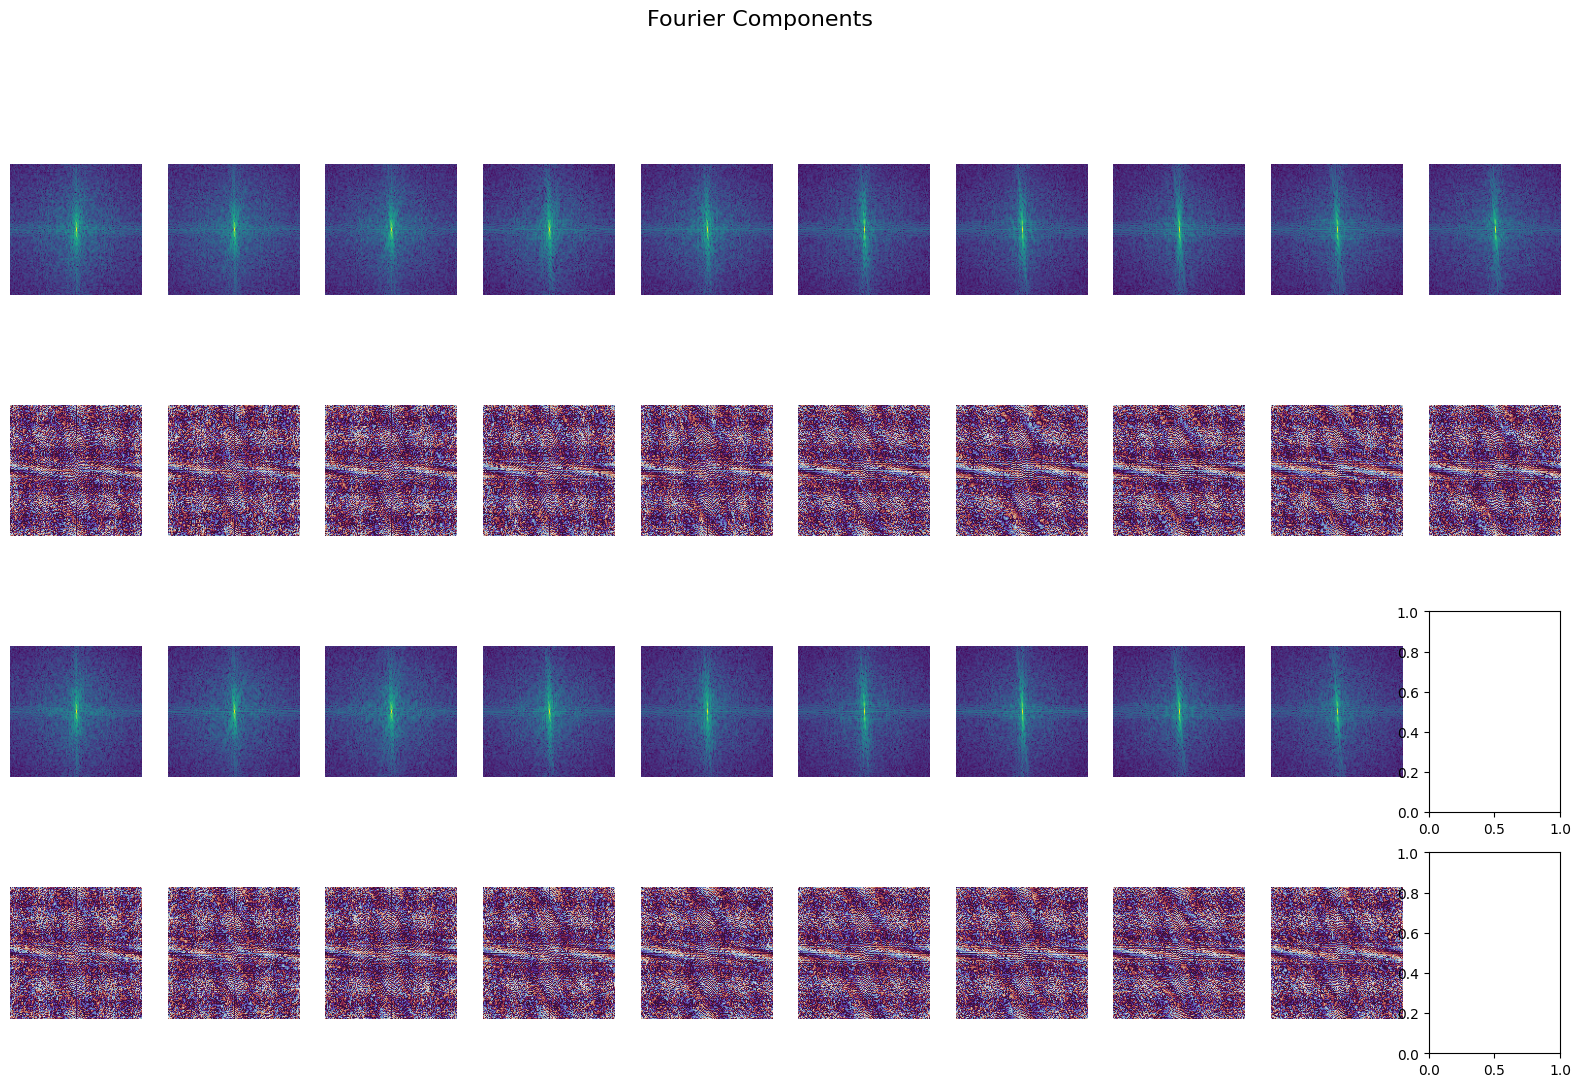

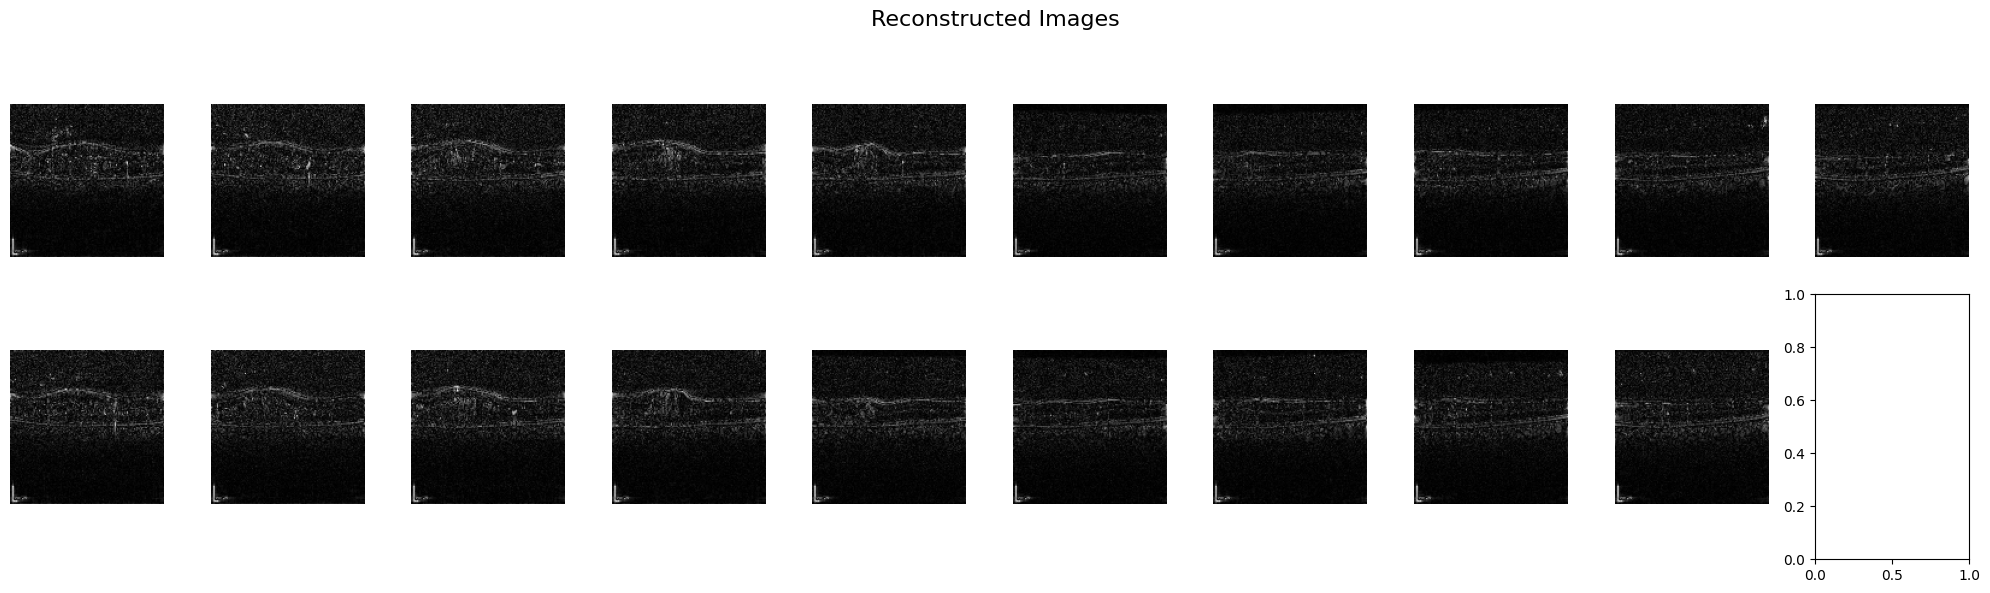

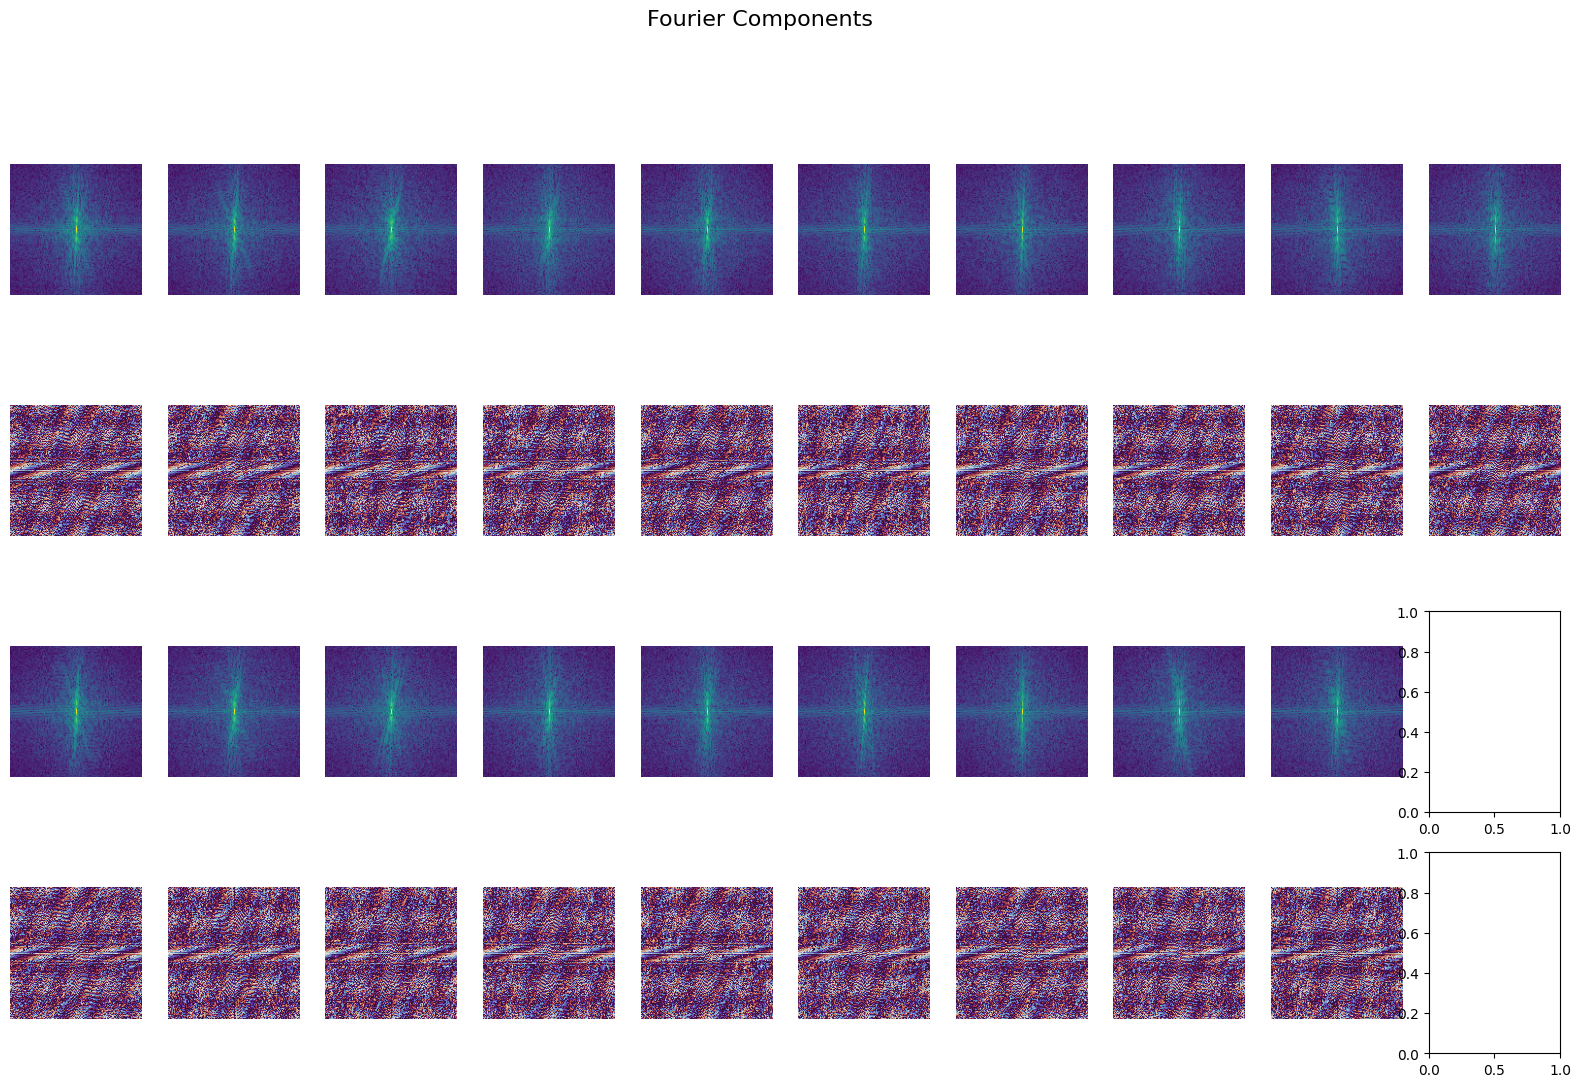

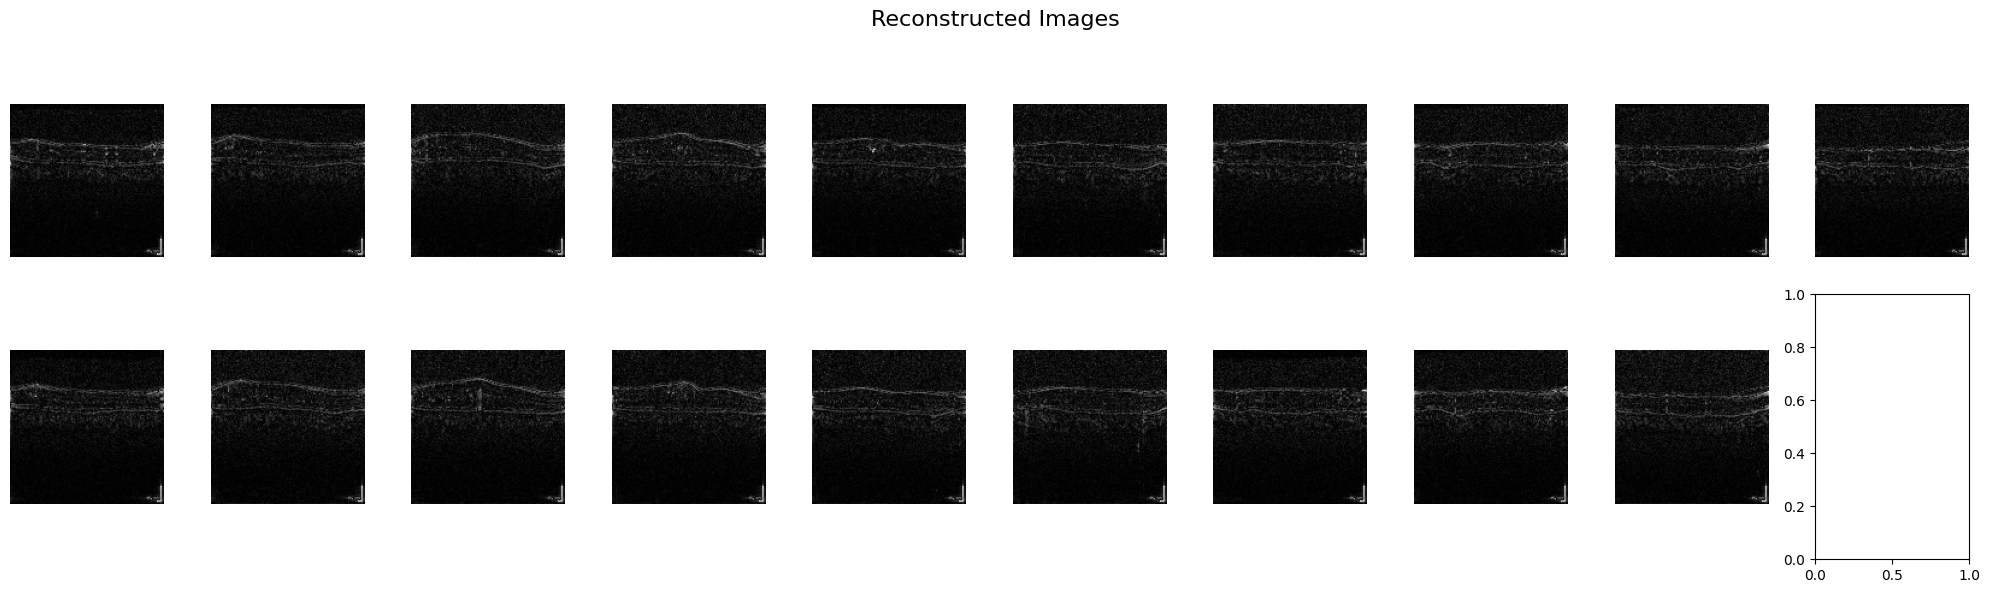

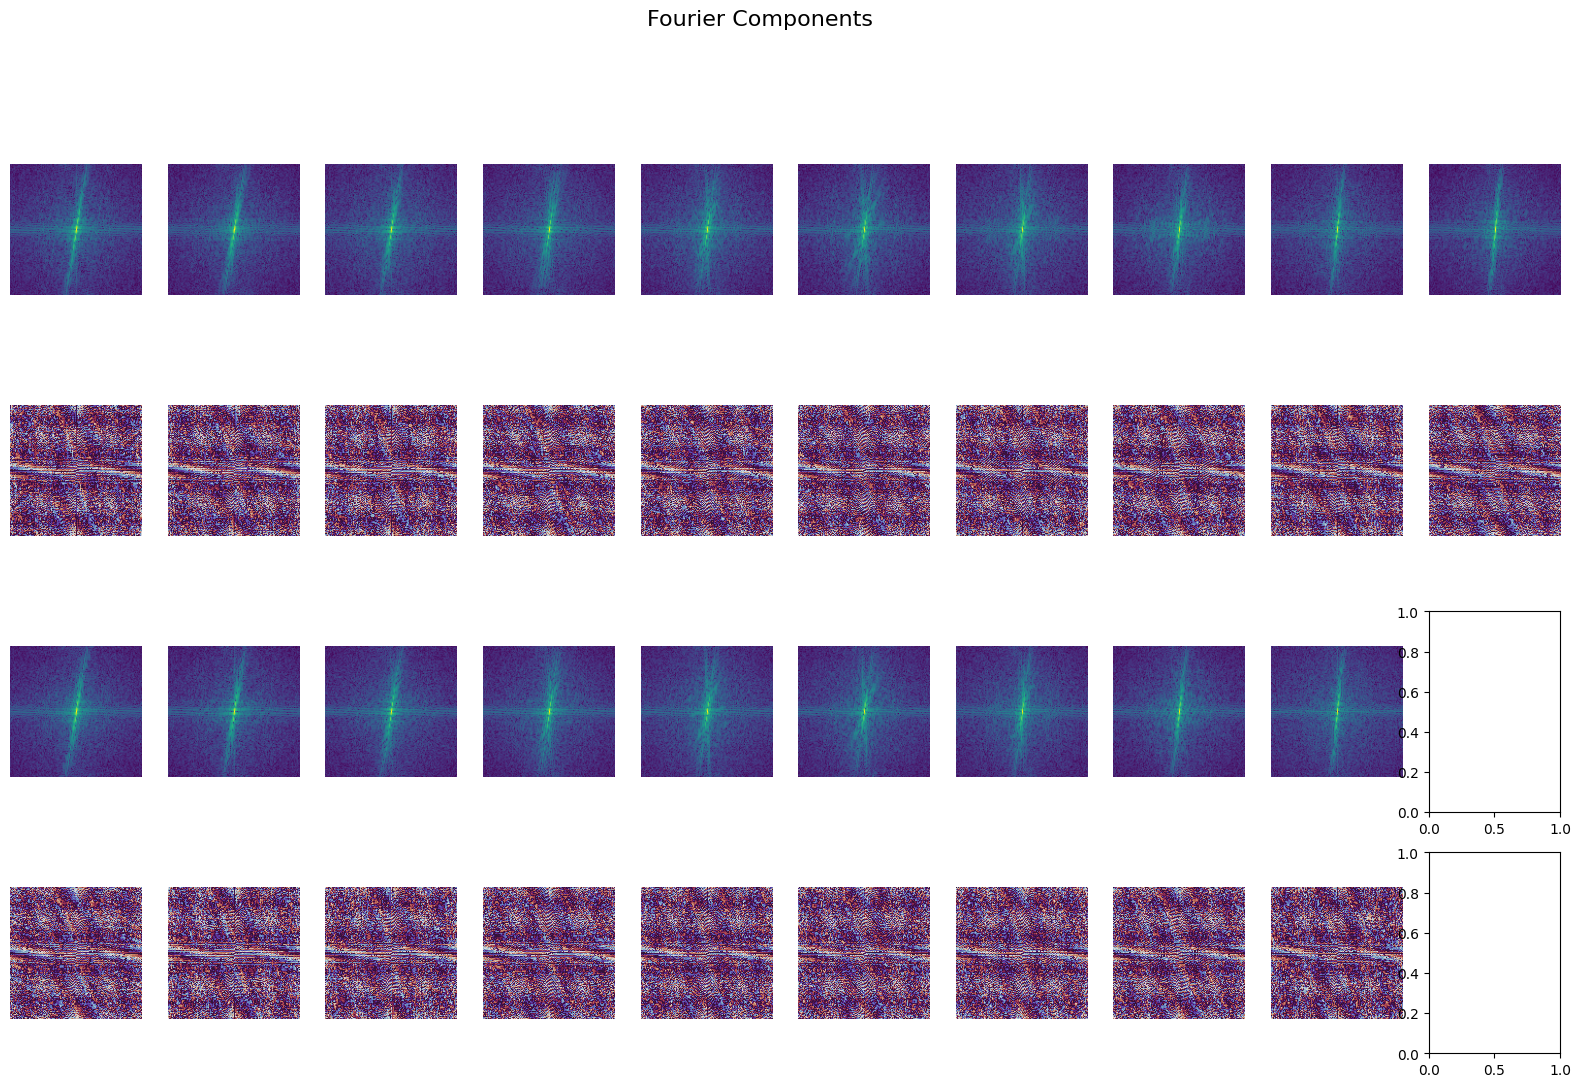

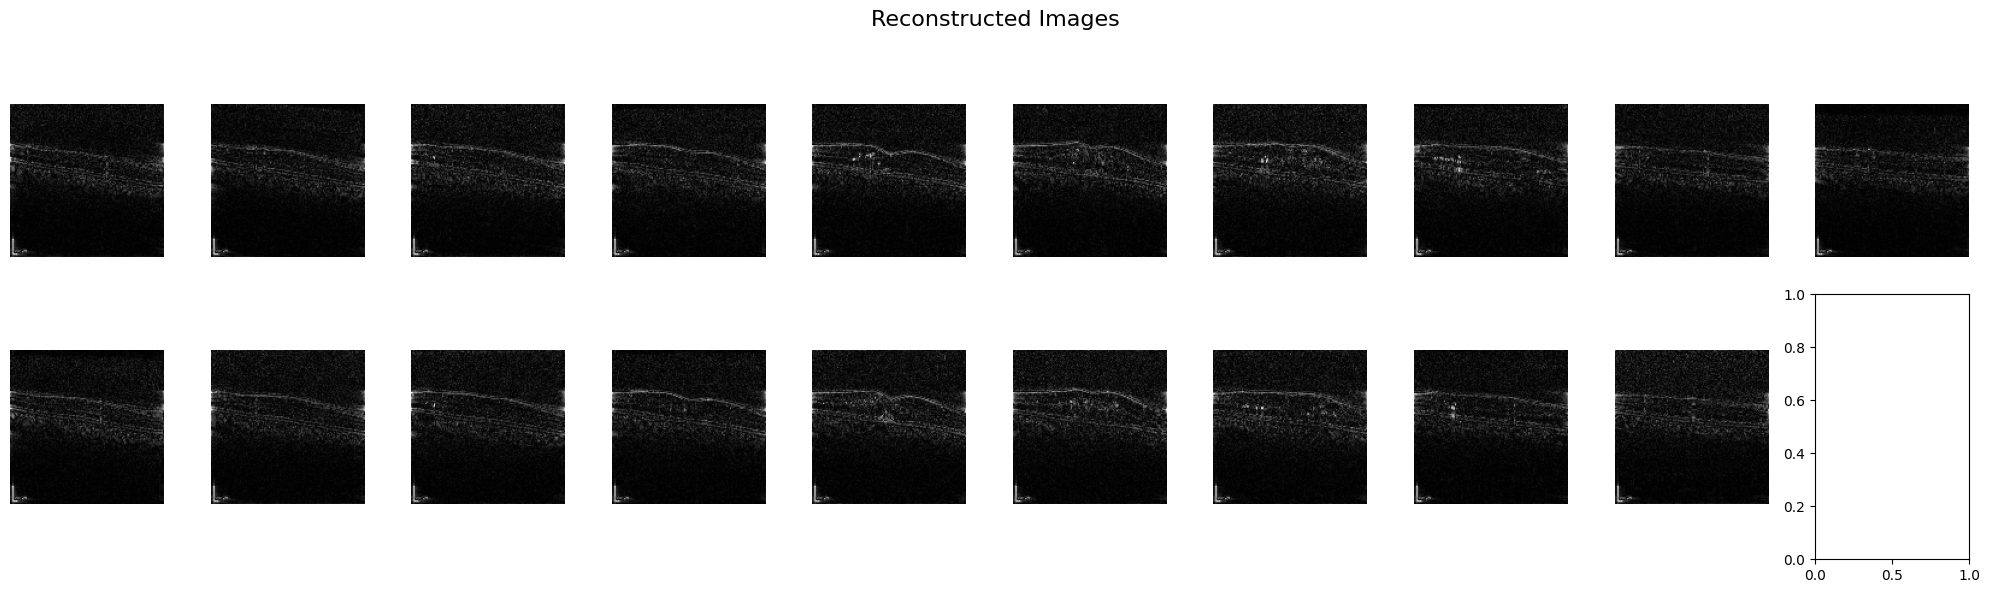

In [23]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Hyperparameters
    BATCH_SIZE = 4
    NUM_EPOCHS = 100
    LEARNING_RATE = 1e-4
    IMAGE_SIZE = 128
    HIDDEN_CHANNELS = 64
    TIME_EMBED_DIM = 32
    
    # Setup data
    dataset = ComplexFourierDataset(
        root_dir='train',  # Update with your data path
        image_size=IMAGE_SIZE
    )
    train_loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    # Initialize model
    model = ComplexUNet(
        input_channels=1,  # Single channel for grayscale images
        condition_channels=2,  # Two surrounding frames as condition
        hidden_channels=HIDDEN_CHANNELS,
        time_embed_dim=TIME_EMBED_DIM
    ).to(device)
    
    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Create timestamp for this training run
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    checkpoint_dir = f'checkpoints_{timestamp}'

    # Initialize logging
    logging.basicConfig(
        level=logging.INFO,
        filemode='w',
        filename='training.log',
        format='%(asctime)s - %(levelname)s - %(message)s',
    )
    
    # Start training
    logging.info("Starting training...")
    train(model, train_loader, optimizer, device, NUM_EPOCHS, checkpoint_dir=checkpoint_dir)
    
    # Save final model
    final_model_path = os.path.join(checkpoint_dir, 'final_model.pt')
    torch.save(model.state_dict(), final_model_path)
    logging.info(f"Training complete. Final model saved to {final_model_path}")

if __name__ == '__main__':
    #vis_main()
    #main()
    vis_main()